In this notebook, we explore the "Rotated MNIST + background images" from https://sites.google.com/a/lisa.iro.umontreal.ca/public_static_twiki/variations-on-the-mnist-digits and build a Data Loader to process this into Dataset objects. Note that in an accompanying notebook, we use a similar neural architecture on the classical MNIST dataset and find very good performance. In fact, the training achieves $>95\%$ accuracy on a validation batch within the first few hundred iterations (after around just 1 epoch). It appears challenging to achieve similar results on the version of the MNIST dataset used here.

A wonderful reference for convolutional arithmetic is __Dumoulin, Vincent, and Francesco Visin. "A guide to convolution arithmetic for deep learning." arXiv preprint arXiv:1603.07285 (2016)__ . One of the basic takeaways is that most of the dimensioning for multivariate tensors can be analyzed by considering single dimensions. This makes accounting for kernel sizes, strides, padding, pooling, etc. more intuitive.  


In [1]:
import requests
import zipfile
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
import torch.nn.functional as F
import argparse
from typing import List, Dict, Any

In [2]:
class BaseDataset(torch.utils.data.Dataset):

  def __init__(self, x,y):
    super().__init__()
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, index):
    'produces a single data point'
    xs = self.x[index]
    ys = self.y[index]

    return xs, ys

class MNISTDataModule:
  '''
  Helper module that downloads, loads, and partitions the MNIST dataset.
  '''
  url = "http://www.iro.umontreal.ca/~lisa/icml2007data/"
  filename = "mnist_rotation_back_image_new.zip"

  def __init__(self, dir, batch_size=32):
      self.dir = dir 
      self.batch_size = batch_size
      self.path = self.dir + '/' +self.filename

  def download_data(self):
    # create directories and download dataset
    if not os.path.exists(self.dir):
      os.mkdir(self.dir)
    if not os.path.exists(self.path):
      content = requests.get(self.url + self.filename).content
      with open(self.path, "wb") as f:
        f.write(content)
    with zipfile.ZipFile(self.path) as f:
      f.extractall(path=self.dir)
      
  def setup(self):
    # load data
    with open(self.dir+'/mnist_all_background_images_rotation_normalized_test.amat', 'r') as f1:
      ds_te = [[float(a) for a in line.split()] for line in f1]
    with open(self.dir+'/mnist_all_background_images_rotation_normalized_train_valid.amat', 'r') as f2:
      ds_tr_val = [[float(a) for a in line.split()]  for line in f2]
      
    ds_te, ds_tr_val = map(torch.tensor, (ds_te, ds_tr_val))

    # hardwired 80%-20% split into training and validation
    n1 = int(0.8*ds_tr_val.shape[0])

    Xtr, Ytr = ds_tr_val[:n1,:-1], ds_tr_val[:n1,-1]
    Xval, Yval = ds_tr_val[n1:,:-1], ds_tr_val[n1:,-1]
    Xte, Yte = ds_te[:,:-1], ds_te[:,-1]
    
    self.train_ds = BaseDataset(Xtr, Ytr)
    self.valid_ds = BaseDataset(Xval, Yval)
    self.test_ds = BaseDataset(Xte, Yte)

  def train_dataloader(self):
    return torch.utils.data.DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

  def val_dataloader(self):
    return torch.utils.data.DataLoader(self.valid_ds, batch_size=3*self.batch_size, shuffle=False)

In [3]:
torch.manual_seed(42)

dir = "/content/data"
bs = 32
dm = MNISTDataModule(dir, batch_size = bs)
dm.download_data()

In [4]:
dm.setup()

In [5]:
train_dl = dm.train_dataloader()

In [6]:
#load a batch of data
dataiter = iter(train_dl)
X,y = dataiter.next()

In [7]:
#verify that the data is normalized
print(X.min().item(), X.max().item())

0.0 1.0


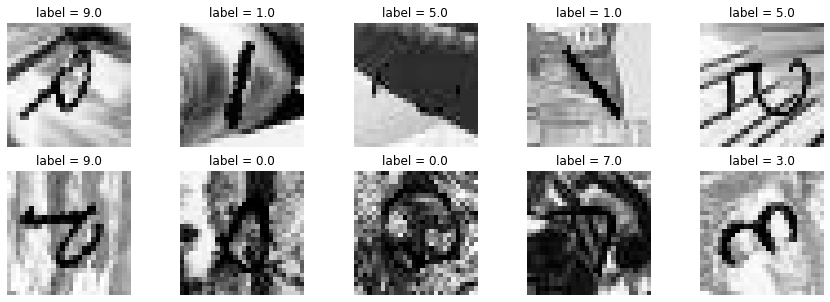

In [8]:
## let's look at some data samples

fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=5)
i = 0
for row in ax:
    for col in row:
        
        col.imshow(X[i].reshape(28,28), cmap='Greys')
        col.set_title('label = '+str(y[i].item()))
        col.set_axis_off()
        i+=1

plt.show()

The digits appear rotated and flipped/mirrored (both horizontally and vertically). Moreover, the digits have been overlayed on various textured backgrounds. Naturally, these backgrounds are irrelevant to the label. The combination of these corruptions renders some of the digits beyond human recognition. But are they beyond machine recognition?

How should we think of this data? Let us suppose the data are random variables $X$ (image) and $Y$ (label) with unknown joint distribution $P_{XY}(x,y)$. We further assume that our training, validation, and test datasets are constructed from i.i.d. samples from $P$. The marginals $P_{X}(x)$, $P_{Y}(y)$ and conditional distributions $P_{X|Y}(x|Y=y)$, $P_{Y|X}(y|X=x)$ describe important information about the dataset. For example,
$P(X|Y=y)$ describes the within-class variability in $X$. Presumably, this will be quite high given the differing backgrounds, rotations, and other transformations applied to the associated digit. Alternatively, $P(Y|X=x)$ is basically what we are trying to model in constructing a classifier. 

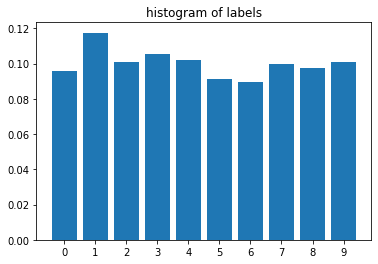

In [9]:
#how balanced is this dataset? Approximate P_Y(y).
Ytr = dm.train_ds.y
label_freqs = torch.zeros(10, dtype=torch.float32)
for y in Ytr:
    label_freqs[int(y.item())] += 1.0
label_freqs *= 1/Ytr.shape[0]
plt.bar(range(10), label_freqs)
plt.xticks(range(10))
plt.title('histogram of labels')
plt.show()

The implication of a balanced dataset is that a probability model in which $X$ and $Y$ are statistically independent and based purely on estimated marginals, i.e., $\hat{P}_{XY}(x,y) = \hat{P}_{X}(x) \hat{P}_{Y}(y)$, will perform poorly on the training data. This is because any classifier based on the conditional $\hat{P}_{Y|X}(y|X=x) = \hat{P}_Y(y)$ is no better than guessing a label uniformly at random. Since such a trivial model performs poorly on the training dataset, we can expect our fitting process to avoid this configuration and produce a model that actually learns some of the dependence structure in the training data. As an aside, if we learn too much from the training dataset, then we are likely to overfit. 

Conversely, if the dataset was severly unbalanced, then the above trivial model could perform well on the training dataset by just guessing the labels that appear more frequently in the training dataset. Such a model is very easy to learn, but will not generalize beyond the training regime.

Note that the model $\hat{P}_{Y|X}(y|X=x) = \hat{P}_Y(y)$ is perhaps the simplest model that one can build from the training data. In the context of MNIST, it contains only $10$ parameters -- the empirical probabilities of each of the $10$ class labels. 

## Building the Neural Network

In [10]:
CONV_DIM = 64
FC_DIM = 256


class ResBlock(nn.Module):
    """
    Residual block with two 3x3 convolutional layers
    Padding size 1 to preserve input dimensionality
    ReLU nonlinearity
    """

    def __init__(self, indim: int, outdim: int, ksize=3, s=1) -> None:
        super().__init__()
        #{in,out}dim = number of filters (each of size ksize_in) in the layer


        self.conv1 = nn.Conv2d(indim, outdim, kernel_size=ksize, stride=s, padding=1)
        self.bn = nn.BatchNorm2d(outdim)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outdim, outdim, kernel_size=ksize, stride=s, padding=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """.

        Inputs
        ----------
        x
            (B, C_in, H_in, W_in) tensor

        Outputs
        -------
        torch.Tensor
            (B, C_out, H_out, W_out) tensor
        """
        z = self.conv1(x)  # (B, C_out, H_in, W_in)
        z = self.bn(z)     # (B, C_out, H_in, W_in)  
        z = self.relu(z)   # (B, C_out, H_in, W_in)
        z = self.conv2(z)  # (B, C_out , H_in, W_in) 
        outs = x+z
        return outs



In [11]:
class ResNet(nn.Module):
    """
    Simple ResNet for the Rotated MNIST dataset
    Recall, the MNIST dataset takes as input (channels, width, height) = (1,28,28) images, i.e., 784 dimensional feature vectors
    and has 10 classes (for the digits 0,1,...,9)
    """

    def __init__(self, args: argparse.Namespace = None) -> None:
        super().__init__()
        self.args = vars(args) if args is not None else {}

        #hardwired for MNIST
        self.input_height, self.input_width = 28,28 
        num_classes = 10

        conv_dim = self.args.get("conv_dim", CONV_DIM) #number of filters / channels
        fc_dim = self.args.get("fc_dim", FC_DIM)


        ## input = (B,C=1,H,W), C=1 as MNIST has just a single channel
        self.res1 = ResBlock(1, conv_dim)   
        self.res2 = ResBlock(conv_dim, conv_dim)
        self.max_pool = nn.MaxPool2d(2)
        self.res3 = ResBlock(conv_dim, conv_dim)
        self.res4 = ResBlock(conv_dim, conv_dim)
        self.res5 = ResBlock(conv_dim, conv_dim)
        self.res6 = ResBlock(conv_dim, conv_dim)
        self.bn2d = nn.BatchNorm2d(conv_dim)
        self.drop = nn.Dropout(0.5)
        conv_output_height, conv_output_width = self.input_height // 4, self.input_width // 4
        self.flatten = nn.Flatten()
        fc_input_dim = int(conv_output_height * conv_output_width * conv_dim)
        self.fc1 = nn.Linear(fc_input_dim, fc_dim)
        self.bn1d = nn.BatchNorm1d(fc_dim)
        self.fc2 = nn.Linear(fc_dim, num_classes)
        self.relu = nn.ReLU()

        #adjust inits
        with torch.no_grad():
          self.fc2.weight *= 0.001
          self.fc2.bias *= 0.001
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Parameters
        ----------
        x
            (B, Ch, H, W) tensor, where H and W must equal input height and width from data_config.

        Returns
        -------
        torch.Tensor
            (B, Classes) tensor
        """
        B, C, H, W = x.shape
        x = self.res1(x)      # (B, CONV_DIM, H, W)
        x = self.res2(x)      # (B, CONV_DIM, H, W)
        x = self.max_pool(x)  # (B, CONV_DIM, H // 2, W // 2)
        x = self.drop(x)
        x = self.res3(x)      # (B, CONV_DIM, H // 2, W // 2)
        x = self.res4(x)      # (B, CONV_DIM, H // 2, W // 2)
        x = self.max_pool(x)  # (B, CONV_DIM, H // 4, W // 4)
        x = self.drop(x)
        x = self.res5(x)      # (B, CONV_DIM, H // 4, W // 4)
        x = self.res6(x)      # (B, CONV_DIM, H // 4, W // 4)
        x = self.bn2d(x)
        x = self.relu(x)
        x = self.flatten(x)   # (B, CONV_DIM * H // 4 * W // 4)
        x = self.fc1(x)       # (B, FC_DIM)
        x = self.bn1d(x)      # (B, FC_DIM)
        x = self.relu(x)      # (B, FC_DIM)
        x = self.fc2(x)       # (B, Classes)
        return x

In [12]:
def accuracy(out: torch.Tensor, yb: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(out, dim=1) 
    return (preds == yb).float().mean() #converts from 0-1 bool to float and then averages = the fraction of correct classifications. 

In [13]:
def fit(net: nn.Module, config_opt: Dict[str, Any]) -> List:
  train_dataloader = config_opt['train_dataloader']
  val_dataloader = config_opt['val_dataloader']
  epochs = config_opt['epochs']
  lr = config_opt['lr']
  wd = config_opt['wd']
  gm = config_opt['lr_gamma']
  loss_func = F.cross_entropy

  optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gm)
  
  valiter = iter(val_dataloader)
  net.train()
  iters = 0
  outfreq = 100
  lossi=[]

  for p in net.parameters():
    p.requires_grad = True

  for epoch in range(epochs):
    for xb, yb in train_dataloader:
      # xb = (B, 28*28), yb = (B,)
      xb.unsqueeze(1) #unsqueezing in a channel dimension
      xb = xb.view(-1,1,28,28)
      yb = yb.long()
      
      logits = net(xb)
      loss = loss_func(logits, yb)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      # tracking
      lossi.append(loss.log10().item())

      # outputs
      if iters % outfreq == 0:
        with torch.no_grad():

          try:
            xv,yv = next(valiter)
          except StopIteration:
            valiter = iter(val_dataloader)
            xv,yv = next(valiter)
          
          xv.unsqueeze(1) #unsqueezing in a channel dimension
          xv = xv.view(-1,1,28,28)
          yv = yv.long()

          net.eval()
          logitsv = net(xv)
          net.train()
          lossv = loss_func(logitsv,yv)
          accv = accuracy(logitsv, yv)
          acctr = accuracy(logits, yb)
          print(f'iter {iters:7d} | epoch {epoch:2d} | loss  {loss.item():.4f} (val: {lossv.item():.4f}) | acc {acctr:.4f} (val: {accv:.4f}) | lr {scheduler.get_last_lr()[-1]:e}') 
      
      iters +=1

    scheduler.step()

  torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': lossi,
            }, 'model.pt')

  return lossi

In [14]:
model = ResNet()
print(sum(p.nelement() for p in model.parameters()))

1213898


In [15]:
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
opts = {'epochs': 20, 'train_dataloader': train_dl, 'val_dataloader': val_dl, 'lr': 1e-2, 'lr_gamma': 0.7, 'wd': 1e-4}
lossi = fit(model, opts)

iter       0 | epoch  0 | loss  2.3026 (val: 3.1436) | acc 0.0938 (val: 0.1354) | lr 1.000000e-02
iter     100 | epoch  0 | loss  1.4558 (val: 1.8593) | acc 0.4375 (val: 0.3333) | lr 1.000000e-02
iter     200 | epoch  0 | loss  1.0419 (val: 1.3765) | acc 0.7188 (val: 0.4896) | lr 1.000000e-02
iter     300 | epoch  1 | loss  1.0636 (val: 1.3241) | acc 0.5625 (val: 0.5729) | lr 7.000000e-03
iter     400 | epoch  1 | loss  1.1339 (val: 1.0000) | acc 0.7188 (val: 0.5938) | lr 7.000000e-03
iter     500 | epoch  1 | loss  0.8821 (val: 0.8116) | acc 0.6875 (val: 0.7604) | lr 7.000000e-03
iter     600 | epoch  2 | loss  0.8556 (val: 0.6518) | acc 0.7188 (val: 0.7812) | lr 4.900000e-03
iter     700 | epoch  2 | loss  0.3892 (val: 0.7175) | acc 0.8750 (val: 0.7396) | lr 4.900000e-03
iter     800 | epoch  2 | loss  0.7330 (val: 0.7240) | acc 0.7500 (val: 0.6979) | lr 4.900000e-03
iter     900 | epoch  3 | loss  0.8234 (val: 0.6613) | acc 0.8125 (val: 0.7604) | lr 3.430000e-03
iter    1000 | epoch

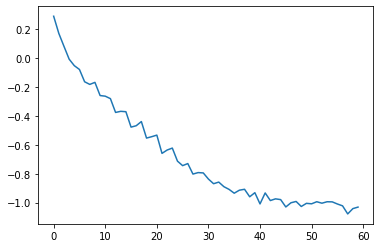

In [16]:
#so far, the best model seems to have a validation accuracy of around 0.9 (on a chosen batch)
plt.plot(torch.tensor(lossi).view(-1,100).mean(dim=1)) 

In [18]:
@torch.no_grad()
def performance(net: nn.Module, datamodule: MNISTDataModule):
  metrics = {'train': {}, 'val': {}, 'test': {}}

  #colab crashes due to limited RAM on the full test set, so we will reduce the test set to the training size
  # ds = {'train': (datamodule.train_ds.x, datamodule.train_ds.y),
  #       'val': (datamodule.valid_ds.x, datamodule.valid_ds.y),
  #       'test': (datamodule.test_ds.x, datamodule.test_ds.y)}
  ds = {'train': (datamodule.train_ds.x, datamodule.train_ds.y),
      'val': (datamodule.valid_ds.x, datamodule.valid_ds.y)}
  train_length = ds['train'][0].shape[0] 
  ds['test'] = (datamodule.test_ds.x[:train_length], datamodule.test_ds.y[:train_length])

  net.eval()
  for key,data in ds.items():
    x = data[0].unsqueeze(1)
    y = data[1].long()
    x = x.view(-1,1,28,28)
    logits = net(x)
    loss = F.cross_entropy(logits, y)
    acc = accuracy(logits, y) 
    metrics[key] = {'loss': loss.item(), 'acc': acc.item()}
  return metrics


perf = performance(model, dm)

In [19]:
print(perf)

{'train': {'loss': 0.03958232328295708, 'acc': 0.9965624809265137}, 'val': {'loss': 0.3708913028240204, 'acc': 0.8870833516120911}, 'test': {'loss': 0.37768736481666565, 'acc': 0.8819791674613953}}


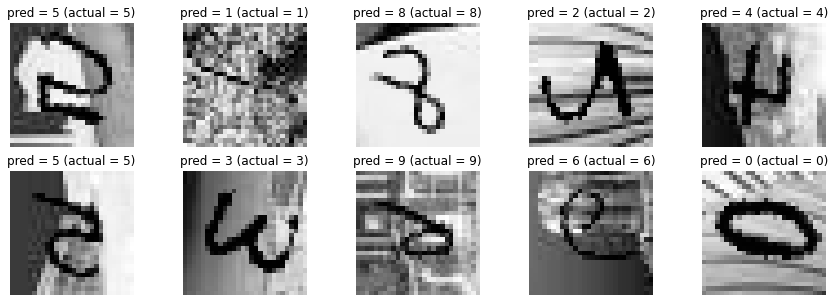

In [20]:
## let's look at some example predictions from the test dataset
Xte, yte = dm.test_ds.x, dm.test_ds.y

model.eval()
with torch.no_grad():
  Xte = Xte[:32].unsqueeze(1)
  yte = yte[:32].long()
  Xte = Xte.view(-1,1,28,28)
  logits = model(Xte) # (B, num_classes)
  ypred = torch.argmax(logits, dim=1) #(B,) 

Xte = Xte.squeeze(1)
fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=5)
i = 0
for row in ax:
    for col in row:
        col.imshow(Xte[i].reshape(28,28), cmap='Greys')
        col.set_title(f'pred = {ypred[i].item():} (actual = {yte[i].item()})')
        col.set_axis_off()
        i+=1

plt.show()

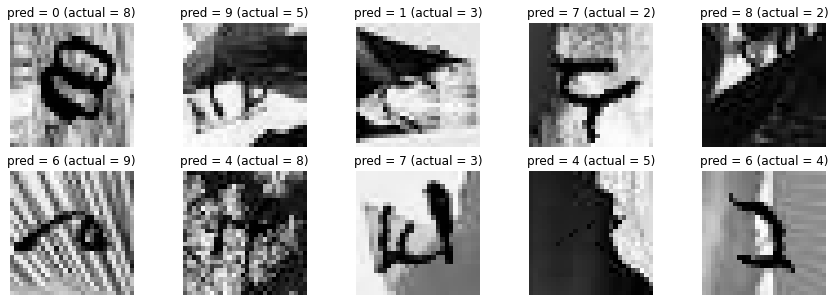

In [21]:
## Now let's focus on mistakes made by the model. What are the modes of failure?

Xte, yte = dm.test_ds.x, dm.test_ds.y
model.eval()

with torch.no_grad():
  Xte = Xte[:1000].unsqueeze(1)
  yte = yte[:1000].long()
  Xte = Xte.view(-1,1,28,28)
  logits = model(Xte) # (B, num_classes)
  ypred = torch.argmax(logits, dim=1) #(B,) 

fails = (ypred != yte).nonzero()

Xfail = Xte[fails].squeeze(1)
yfail = ypred[fails]
ytrue = yte[fails]

fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=5)
i = 0
for row in ax:
    for col in row:
        col.imshow(Xfail[i].reshape(28,28), cmap='Greys')
        col.set_title(f'pred = {yfail[i].item():} (actual = {ytrue[i].item()})')
        col.set_axis_off()
        i+=1


Many of these failure modes are understandable. Several of the above cases appear beyond human recognition -- these images don't seem to share any commonality with other members of their class. Moreover, at least one of the images appears mislabeled. 

Other errors, such as the model mislabeling 8s as 0s. These errors are fixable.

There are many follow up questions that one may ask. For example, we may wish to understand what features are being picked up by the convolutional filters in each layer. Moreover, it would be interesting to look at how diverse the filters are in the same layer. I plan to add this later.

One question that I think is interesting is as follows. This corrupted version of the MNIST dataset is derived from the basic MNIST dataset. Of course, the differences are that the digits have been rotated and overlayed over textured backgrounds. In an accompanying notebook, we saw that the above model architecture can get $>98\%$ accuracy quite easily, which I guess is typical for these problems. Will our current model -- trained on a corrupted version of MNIST -- perform well on the original MNIST? 

In [26]:
# Downloading original MNIST, note the normalization is the same as with the corrupted MNIST
url = "http://www.iro.umontreal.ca/~lisa/icml2007data/"
filename = "mnist.zip"
dir = "/content/data1"
path = dir+'/'+filename

if not os.path.exists(dir):
  os.mkdir(dir)
if not os.path.exists(path):
  content = requests.get(url + filename).content
  with open(path, "wb") as f:
    f.write(content)
with zipfile.ZipFile(path) as f:
  f.extractall(path=dir)

with open(dir+'/mnist_test.amat', 'r') as f1:
  ds_te = [[float(a) for a in line.split()] for line in f1]
with open(dir+'/mnist_train.amat', 'r') as f2:
  ds_tr_val = [[float(a) for a in line.split()]  for line in f2]
  
ds_te, ds_tr_val = map(torch.tensor, (ds_te, ds_tr_val))

# hardwired 80%-20% split into training and validation
n1 = int(0.8*ds_tr_val.shape[0])

Xtr, ytr = ds_tr_val[:n1,:-1], ds_tr_val[:n1,-1]
# Xval, yval = ds_tr_val[n1:,:-1], ds_tr_val[n1:,-1]
# Xte, yte = ds_te[:,:-1], ds_te[:,-1]

In [27]:
# Let's just test on a subset of the MNIST training points
with torch.no_grad():
  Xtr = Xtr[:1000].unsqueeze(1)
  ytr = ytr[:1000].long()
  Xtr = Xtr.view(-1,1,28,28)
  logits = model(Xtr) # (B, num_classes)
  acc = accuracy(logits, ytr)
  ypred = torch.argmax(logits, dim=1) #(B,) 

print(f'acc {acc.item():.4f}')

acc 0.4940


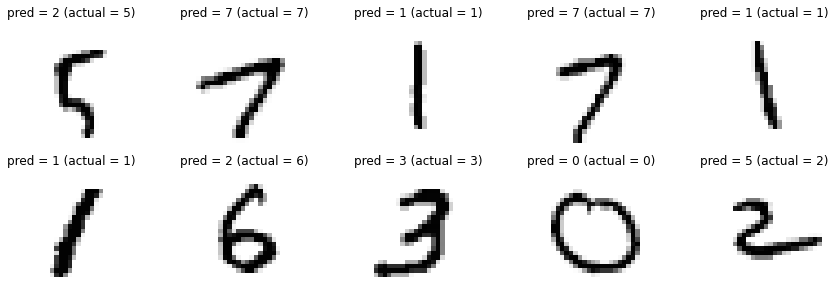

In [29]:
fig, ax = plt.subplots(figsize=(15, 5), nrows=2, ncols=5)
i = 100
for row in ax:
    for col in row:
        col.imshow(Xtr[i].reshape(28,28), cmap='Greys')
        col.set_title(f'pred = {ypred[i].item():} (actual = {ytr[i].item()})')
        col.set_axis_off()
        i+=1

Apparently it performs no better than random guessing. But the errors sort of make sense. In several of the images, the model predicts $2$ whereas the true label is $5$. These digits do look similar when accounting for rotations and possible mirroring. 